In [60]:
import glob
from collections import defaultdict
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pymutspec.annotation import CodonAnnotation, mutations_summary

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error
from Bio import SeqIO

import warnings
warnings.filterwarnings("ignore")

from utils import prepare_exp_aa_subst, prepare_aa_subst, get_equilibrium_freqs, calc_metrics, amino_acid_codes

In [2]:
coda = CodonAnnotation(2)

## Analyse vertebrates

In [4]:
ms12 = pd.read_csv('../192/1data_derivation/dataset/MutSpecVertebrates12.csv.gz')
ms12

,Gene,Class,Species,Mut,Observed,Expected,MutSpec
0,CO1,Mammalia,Crocuta_crocuta,A>C,NaN,115.066667,0.000000
1,CO1,Mammalia,Crocuta_crocuta,A>G,11.500444,173.333333,0.162818
2,CO1,Mammalia,Crocuta_crocuta,A>T,NaN,115.066667,0.000000
3,CO1,Mammalia,Crocuta_crocuta,C>A,NaN,71.466667,0.000000
4,CO1,Mammalia,Crocuta_crocuta,C>G,NaN,71.466667,0.000000
...,...,...,...,...,...,...,...
34387,CO3,Actinopteri,Cottus_gulosus,G>C,NaN,7.166667,0.000000
34388,CO3,Actinopteri,Cottus_gulosus,G>T,NaN,7.166667,0.000000
34389,CO3,Actinopteri,Cottus_gulosus,T>A,0.600700,32.500000,0.029888
34390,CO3,Actinopteri,Cottus_gulosus,T>C,1.384498,64.916667,0.034487


In [20]:
cls_spectra = {}
cls_eqs = {}
for _cls, df_cls in ms12.groupby('Class'):
    cls_spectra[_cls] = df_cls.query('Gene == "Cytb"').groupby('Mut').MutSpec.mean().reset_index()
    _, aa_eq = get_equilibrium_freqs(cls_spectra[_cls], gc=2)
    cls_eqs[_cls] = aa_eq.set_index('aa').eq_freq.rename(_cls)

cls_spectra['Mammalia']

,Mut,MutSpec
0,A>C,0.006995
1,A>G,0.067613
2,A>T,0.012740
3,C>A,0.024510
4,C>G,0.005048
5,C>T,0.124436
6,G>A,0.480826
7,G>C,0.021098
8,G>T,0.019011
9,T>A,0.014834


<Axes: xlabel='aa'>

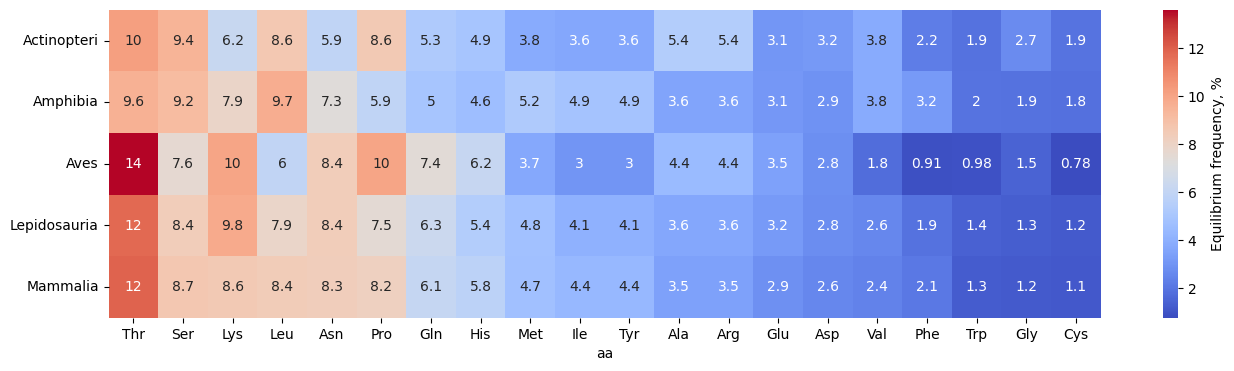

In [32]:
_ = pd.DataFrame(cls_eqs).sort_values('Mammalia', ascending=False) * 100

plt.figure(figsize=(16, 4))
sns.heatmap(_.T, annot=True, cmap='coolwarm', cbar_kws={'label': 'Equilibrium frequency, %'})

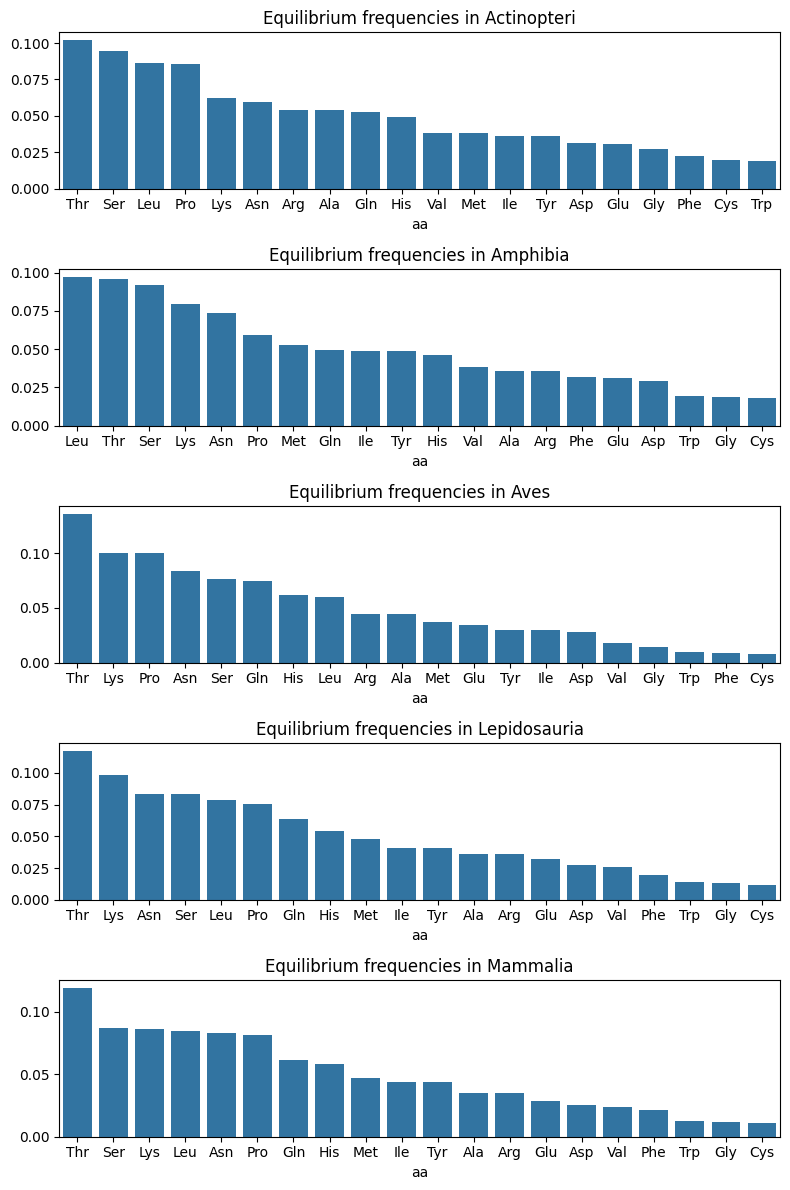

In [45]:
plt.figure(figsize=(8, 12))
for i, _cls in enumerate(cls_eqs):
    plt.subplot(5, 1, i + 1)
    plt.title(f'Equilibrium frequencies in {_cls}')
    sns.barplot(x=cls_eqs[_cls].index, y=cls_eqs[_cls].values)
plt.tight_layout()

In [92]:
obs_df_ns_flt = pd.read_csv('./vertebrates_aa_subst/dataset/obs_muts.csv')
obs_df_ns_flt

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene,class,edge_nobs,species_nobs
0,A[A>G]T,0,112,1,ATT,GTT,I,V,0.958489,0.849141,Node5,Node6,Macaca_mulatta,ND6,Mammalia,1.70197,60.8728
1,T[G>A]T,0,127,1,GTT,ATT,V,I,0.974793,0.970650,Node6,Node12,Macaca_mulatta,ND6,Mammalia,4.31735,60.8728
2,G[A>G]T,0,301,1,ATA,GTA,M,V,0.999990,0.999990,Node24,RN_6,Macaca_mulatta,ND6,Mammalia,0.99999,60.8728
3,T[G>A]T,0,109,1,GTA,ATA,V,M,0.999990,0.999990,Node22,RN_32,Macaca_mulatta,ND6,Mammalia,0.99999,60.8728
4,A[A>G]T,0,97,1,ATT,GTT,I,V,1.000000,1.000000,Node25,RN_5,Macaca_mulatta,ND6,Mammalia,1.00000,60.8728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71036,G[T>C]T,0,320,2,GTT,GCT,V,A,0.997300,0.996791,Node7,Node15,Microtus_richardsoni,CO3,Mammalia,2.99087,37.8538
71037,A[G>A]C,0,470,2,AGC,AAC,S,N,0.976132,0.976132,Node8,Node14,Microtus_richardsoni,CO3,Mammalia,5.21561,37.8538
71038,A[C>T]T,0,139,1,CTT,TTT,L,F,0.980432,0.980432,Node9,RN_10,Microtus_richardsoni,CO3,Mammalia,5.85689,37.8538
71039,A[A>G]T,0,574,1,ATC,GTC,I,V,0.960485,0.960485,Node9,RN_10,Microtus_richardsoni,CO3,Mammalia,5.85689,37.8538


In [5]:
# TODO - split to genes and maybe classes

In [132]:
# derive aa content from fasta file
from collections import Counter
path_to_fasta = '../192/1data_derivation/nemu_input/Cytb.fasta'
aa_content = {_cls: [] for _cls in cls_spectra}
nerr = 0
for rec in SeqIO.parse(path_to_fasta, 'fasta'):
    cur_aa_content = Counter(rec.seq)
    _cls = rec.description.split('###Chordata_7711;')[1].split('_')[0]
    if _cls not in aa_content:
        nerr += 1
        continue
    aa_content[_cls].append(cur_aa_content)

aa_content_mean = {}
for _cls in aa_content:
    aa_content_mean[_cls] = pd.DataFrame(aa_content[_cls]).rename(columns=amino_acid_codes)\
        .fillna(0).mean().to_dict()
    for x in ['X', 'B', 'Z', 'J']:
        if x in aa_content_mean[_cls]:
            del aa_content_mean[_cls][x]

nerr

154

In [137]:
for _cls in aa_content_mean:
    obs_aa_mut = obs_df_ns_flt.query('gene == "Cytb" & `class` == @_cls')\
        .rename(columns={'ProbaMut': 'count', 'RefAa': 'aa1', 'AltAa': 'aa2'})
    exp_aa_subst = prepare_exp_aa_subst(cls_spectra[_cls], 'MutSpec', 2)[0]
    aa_subst = prepare_aa_subst(obs_aa_mut, exp_aa_subst, aa_content_mean[_cls])
    metr = calc_metrics(aa_subst)
    metr['class'] = _cls
    print(_cls, metr['pearson_corr']**2, metr['r2'])

Actinopteri 0.35107961069009536 0.1487047968887264
Amphibia 0.3363370840905314 0.2938798263324567
Aves 0.3686969616775849 0.2761764860846042
Lepidosauria 0.3813790009125735 0.25039007309272354
Mammalia 0.4051658221744695 0.3549100833973525


In [138]:
metr

{'r2': 0.3549100833973525,
 'mape': 1.4633380598001273,
 'wape': 0.8174694287430023,
 'slope': np.float64(0.5478609787867941),
 'intercept': np.float64(0.0032295644372371843),
 'spearman_corr': np.float64(0.5392826504362745),
 'spearman_p': np.float64(6.2242279720592235e-12),
 'pearson_corr': np.float64(0.6365263719395053),
 'pearson_p': np.float64(2.859387657538147e-17),
 'ks_stat': np.float64(0.2),
 'ks_p': np.float64(0.007266829072827465),
 'rmse': 0.010697204045374172,
 'log_likelihood': np.float64(-5.6198974591614235),
 'mut_count': np.float64(14038.639030999997),
 'mut_type_count': np.int64(140),
 'class': 'Mammalia'}

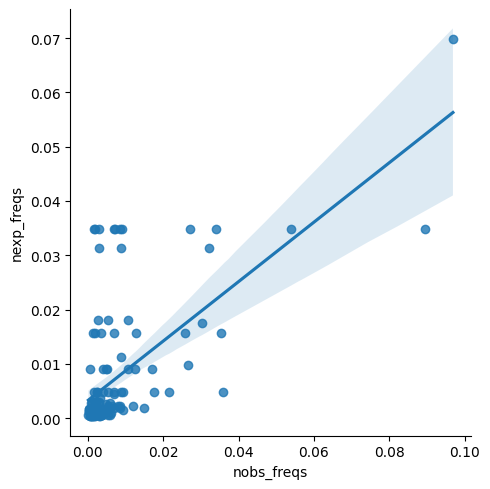

In [141]:
sns.lmplot(aa_subst, x='nobs_freqs', y='nexp_freqs')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

## Human mtDNA megatree

In [ ]:
megatree_mut = pd.read_csv('external_datasets/raw_human_megatree.csv')
megatree_mut = megatree_mut[(megatree_mut.TypeRef == 'CDS') & 
                            (megatree_mut.Label == 0) & 
                            (megatree_mut.GeneRef != 'ND6')]

aa_subst_megatree = megatree_mut.groupby(['Aa1', 'Aa2']).ProbaFull.sum().reset_index()
aa_subst_megatree.columns = ['aa1', 'aa2', 'nobs']
aa_subst_megatree['aa1'] = aa_subst_megatree['aa1'].map(amino_acid_codes)
aa_subst_megatree['aa2'] = aa_subst_megatree['aa2'].map(amino_acid_codes)
aa_subst_megatree = aa_subst_megatree.merge(exp_aa_subst, how='right')\
    .fillna(0).rename(columns={'rate': 'rate_exp'})
aa_subst_megatree['nexp'] = aa_subst_megatree.rate_exp / aa_subst_megatree.rate_exp.sum() * aa_subst_megatree.nobs.sum()
aa_subst_megatree['diff'] = aa_subst_megatree.nobs - aa_subst_megatree.nexp
aa_subst_megatree['nobs_freqs'] = aa_subst_megatree.nobs / aa_subst_megatree.nobs.sum()
aa_subst_megatree['nexp_freqs'] = aa_subst_megatree.nexp / aa_subst_megatree.nexp.sum()
aa_subst_megatree

,aa1,aa2,nobs,rate_exp,nexp,diff,nobs_freqs,nexp_freqs
0,Ala,Asp,6.957436,0.051108,37.297973,-30.340537,0.000345,0.001850
1,Ala,Glu,1.972349,0.051108,37.297973,-35.325624,0.000098,0.001850
2,Ala,Gly,11.929035,0.028130,20.529105,-8.600070,0.000592,0.001018
3,Ala,Pro,24.693096,0.116582,85.080238,-60.387142,0.001225,0.004220
4,Ala,Ser,53.389118,0.073379,53.550954,-0.161836,0.002648,0.002656
...,...,...,...,...,...,...,...,...
135,Val,Gly,20.782732,0.033067,24.131999,-3.349267,0.001031,0.001197
136,Val,Ile,1235.886978,0.956453,698.008689,537.878289,0.061305,0.034624
137,Val,Leu,37.791339,0.153271,111.855460,-74.064121,0.001875,0.005548
138,Val,Met,451.022055,0.956453,698.008689,-246.986634,0.022372,0.034624


In [15]:
observed_counts = aa_subst_megatree.nobs.values
expected_counts = aa_subst_megatree.nexp.values
total_counts = np.sum(observed_counts)

# 2. Критерий Колмогорова-Смирнова
ks_stat, ks_p = ks_2samp(observed_counts, expected_counts)
print(f"KS статистика: {ks_stat:.2f}, p-value: {ks_p:.3f}")

# 3. Логарифмическое правдоподобие (Log-Likelihood)
log_likelihood = np.sum(observed_counts/observed_counts.sum() * \
                        np.log(expected_counts/expected_counts.sum()) + \
                            (1 - observed_counts/observed_counts.sum()) * \
                                np.log(1 - expected_counts/expected_counts.sum()))
print(f"Логарифмическое правдоподобие: {log_likelihood:.2f}")

# 4. Среднеквадратичная ошибка (MSE)
rmse = mean_squared_error(observed_counts, expected_counts) ** 0.5
print(f"RMSE: {rmse:.2f}")

# 5. Корреляция Спирмена
spearman_corr, spearman_p = spearmanr(observed_counts, expected_counts)
print(f"Корреляция Спирмена: {spearman_corr:.2f}, p-value: {spearman_p:.3f}")

# 6. KL-дивергенция
kl_divergence = np.sum(kl_div(observed_counts/observed_counts.sum(), 
                              expected_counts/expected_counts.sum()))
print(f"KL-дивергенция: {kl_divergence:.2f}")

# 7. Бутстреп-тест (пример)
def bootstrap_test(observed, expected, n_iterations=1000):
    differences = observed - expected
    bootstrap_samples = np.random.choice(differences, size=(n_iterations, len(differences)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    observed_mean_diff = np.mean(differences)
    p_value = np.mean(bootstrap_means >= observed_mean_diff)
    return p_value

bootstrap_p = bootstrap_test(observed_counts, expected_counts)
print(f"Бутстреп p-value: {bootstrap_p:.2f}")


megatree_metrics = {
    'dataset': 'megatree',
    'ks_stat': ks_stat,
    'ks_p': ks_p,
    'log_likelihood': log_likelihood,
    'rmse': rmse,
    'rmse_scaled': rmse / total_counts,
    'spearman_corr': spearman_corr,
    'spearman_p': spearman_p,
    'kl_divergence': kl_divergence,
    'bootstrap_p': bootstrap_p,
    'total_counts': total_counts,
}

KS статистика: 0.44, p-value: 0.000
Логарифмическое правдоподобие: -5.09
RMSE: 335.45
Корреляция Спирмена: 0.66, p-value: 0.000
KL-дивергенция: 0.71
Бутстреп p-value: 0.47


## Human cancer TCGA

In [14]:
cancer_mut = pd.read_csv('https://raw.githubusercontent.com/mitoclub/mtdna-192component-mutspec-chordata/refs/heads/main/0cancer/data/mutations.csv')
cancer_mut = cancer_mut[(cancer_mut.Type == 'CDS') & (cancer_mut.Label == 0) & (cancer_mut.GeneName != 'ND6')]
cancer_mut['aa1'] = cancer_mut.apply(lambda x: amino_acid_codes[coda.translate_codon(x.Codon)], axis=1)
cancer_mut['aa2'] = cancer_mut.apply(lambda x: amino_acid_codes[coda.translate_codon(x.AltCodon)], axis=1)
assert cancer_mut.Strand.nunique() == 1
aa_subst_cancer = cancer_mut.groupby(['aa1', 'aa2']).size().reset_index()
aa_subst_cancer.columns = ['aa1', 'aa2', 'nobs']
aa_subst_cancer = aa_subst_cancer.merge(exp_aa_subst, how='right')\
    .fillna(0).rename(columns={'rate': 'rate_exp'})
aa_subst_cancer['nexp'] = aa_subst_cancer.rate_exp / aa_subst_cancer.rate_exp.sum() * aa_subst_cancer.nobs.sum()
aa_subst_cancer['diff'] = aa_subst_cancer.nobs - aa_subst_cancer.nexp
aa_subst_cancer['nobs_freqs'] = aa_subst_cancer.nobs / aa_subst_cancer.nobs.sum()
aa_subst_cancer['nexp_freqs'] = aa_subst_cancer.nexp / aa_subst_cancer.nexp.sum()
aa_subst_cancer

,aa1,aa2,nobs,rate_exp,nexp,diff,nobs_freqs,nexp_freqs
0,Ala,Asp,5.0,0.051108,6.257119,-1.257119,0.001478,0.001850
1,Ala,Glu,0.0,0.051108,6.257119,-6.257119,0.000000,0.001850
2,Ala,Gly,2.0,0.028130,3.443969,-1.443969,0.000591,0.001018
3,Ala,Pro,19.0,0.116582,14.273086,4.726914,0.005618,0.004220
4,Ala,Ser,3.0,0.073379,8.983724,-5.983724,0.000887,0.002656
...,...,...,...,...,...,...,...,...
135,Val,Gly,1.0,0.033067,4.048391,-3.048391,0.000296,0.001197
136,Val,Ile,94.0,0.956453,117.098147,-23.098147,0.027794,0.034624
137,Val,Leu,12.0,0.153271,18.764905,-6.764905,0.003548,0.005548
138,Val,Met,98.0,0.956453,117.098147,-19.098147,0.028977,0.034624


In [15]:
from sklearn.metrics import r2_score

def plot_subst_freqs(aa_subst, title=''):
    aa_subst = aa_subst.copy()
    aa_subst['nobs_freqs_log'] = np.log10(aa_subst['nobs_freqs'])
    aa_subst['nexp_freqs_log'] = np.log10(aa_subst['nexp_freqs'])

    y_true, y_pred = aa_subst['nobs_freqs'], aa_subst['nexp_freqs']
    cor_res = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Spearman correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

    plt.figure(figsize=(8, 8))
    ax = sns.regplot(aa_subst[aa_subst['nobs_freqs']>0], 
                color='blue', scatter_kws={'alpha':0.5, 's':50},
                y='nobs_freqs_log', x='nexp_freqs_log')

    ticks = np.linspace(-4, -1, 4)
    ticks_minor = np.log10(np.concat([
        np.linspace(10**-4, 10**-3, 10),
        np.linspace(10**-3, 10**-2, 10)[1:],
        np.linspace(10**-2, 10**-1, 10)[1:],
    ]))
    ax.set_xticks(ticks, ticks, size=14)
    ax.set_yticks(ticks, ticks, size=14)
    ax.set_xticks(ticks_minor, minor=True)
    ax.set_yticks(ticks_minor, minor=True)
    formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    # ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
    # ax.get_xaxis().set_minor_locator(LogLocator())

    # plt.text(-2, -4., 
    #          f"r={cor_res.correlation:.1f} (p={cor_res.pvalue:.1g})", 
    #          fontsize=10)
    plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
    plt.ylabel('Observed AA substitution frequencies', fontsize=14)
    plt.xlabel('Predicted AA substitution frequencies', fontsize=14)
    plt.title(title, fontsize=16)
    # plt.legend(title=f"spearmanr={cor_res.correlation:.2f} (p={cor_res.pvalue:.1g})", title_fontsize=14)
    plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)
    # plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
    plt.show()

Spearman correlation: 0.764 (p-value: 4.45e-28)


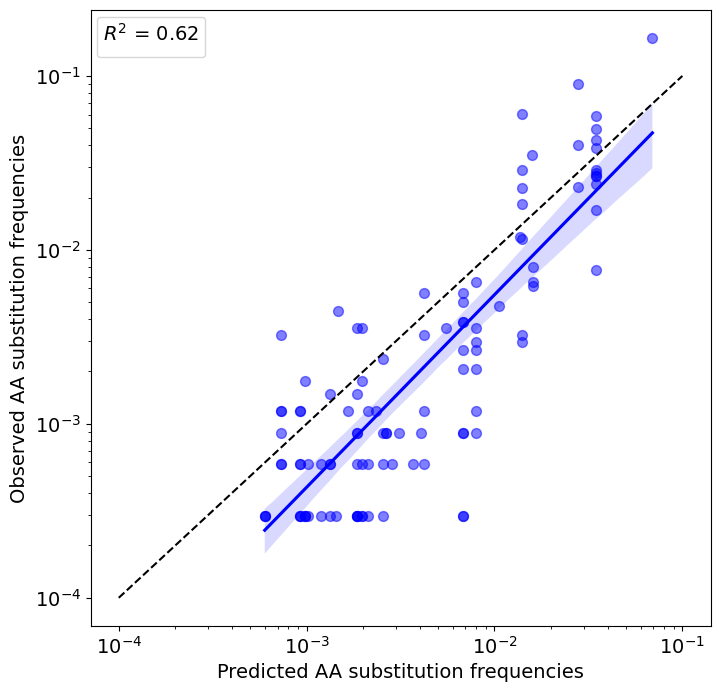

In [ ]:
plot_subst_freqs(aa_subst_cancer) # TODO plot correct fig with correct normalization 
# TODO (use fungtions from utils.py)

In [17]:
observed_counts = aa_subst_cancer.nobs.values
expected_counts = aa_subst_cancer.nexp.values
total_counts = np.sum(observed_counts)

# 2. Критерий Колмогорова-Смирнова
ks_stat, ks_p = ks_2samp(observed_counts, expected_counts)
print(f"KS статистика: {ks_stat:.2f}, p-value: {ks_p:.3f}")

# 3. Логарифмическое правдоподобие (Log-Likelihood)
log_likelihood = np.sum(observed_counts/observed_counts.sum() * \
                        np.log(expected_counts/expected_counts.sum()) + \
                            (1 - observed_counts/observed_counts.sum()) * \
                                np.log(1 - expected_counts/expected_counts.sum()))
print(f"Логарифмическое правдоподобие: {log_likelihood:.2f}")

# 4. Среднеквадратичная ошибка (MSE)
rmse = mean_squared_error(observed_counts, expected_counts) ** 0.5
print(f"RMSE: {rmse:.2f}")

# 5. Корреляция Спирмена
spearman_corr, spearman_p = spearmanr(observed_counts, expected_counts)
print(f"Корреляция Спирмена: {spearman_corr:.2f}, p-value: {spearman_p:.3f}")

# 6. KL-дивергенция
kl_divergence = np.sum(kl_div(observed_counts/observed_counts.sum(), 
                              expected_counts/expected_counts.sum()))
print(f"KL-дивергенция: {kl_divergence:.2f}")

# 7. Бутстреп-тест (пример)
def bootstrap_test(observed, expected, n_iterations=1000):
    differences = observed - expected
    bootstrap_samples = np.random.choice(differences, size=(n_iterations, len(differences)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    observed_mean_diff = np.mean(differences)
    p_value = np.mean(bootstrap_means >= observed_mean_diff)
    return p_value

bootstrap_p = bootstrap_test(observed_counts, expected_counts)
print(f"Бутстреп p-value: {bootstrap_p:.2f}")


cancer_metrics = {
    'dataset': 'cancer',
    'ks_stat': ks_stat,
    'ks_p': ks_p,
    'log_likelihood': log_likelihood,
    'rmse': rmse,
    'rmse_scaled': rmse / total_counts,
    'spearman_corr': spearman_corr,
    'spearman_p': spearman_p,
    'kl_divergence': kl_divergence,
    'bootstrap_p': bootstrap_p,
    'total_counts': total_counts,
}

KS статистика: 0.47, p-value: 0.000
Логарифмическое правдоподобие: -4.72
RMSE: 39.95
Корреляция Спирмена: 0.76, p-value: 0.000
KL-дивергенция: 0.34
Бутстреп p-value: 0.46


## MITOMAP somatic mutations

In [18]:
# https://www.mitomap.org/foswiki/bin/view/MITOMAP/MutationsSomatic

mitomap_mut = pd.read_csv('external_datasets/MutationsSomatic_MITOMAP_Foswiki.csv')
mitomap_mut = mitomap_mut[mitomap_mut['Amino Acid Change'].str.match('[A-Z]-[A-Z]$')]
mitomap_mut['aa1'] = mitomap_mut['Amino Acid Change'].str.split('-').str[0].map(amino_acid_codes)
mitomap_mut['aa2'] = mitomap_mut['Amino Acid Change'].str.split('-').str[1].map(amino_acid_codes)

aa_subst_mitomap = mitomap_mut.groupby(['aa1', 'aa2']).size().reset_index()
aa_subst_mitomap.columns = ['aa1', 'aa2', 'nobs']
aa_subst_mitomap = aa_subst_mitomap.merge(exp_aa_subst, how='right')\
    .fillna(0).rename(columns={'rate': 'rate_exp'})
aa_subst_mitomap['nexp'] = aa_subst_mitomap.rate_exp / aa_subst_mitomap.rate_exp.sum() * aa_subst_mitomap.nobs.sum()
aa_subst_mitomap['diff'] = aa_subst_mitomap.nobs - aa_subst_mitomap.nexp
aa_subst_mitomap['nobs_freqs'] = aa_subst_mitomap.nobs / aa_subst_mitomap.nobs.sum()
aa_subst_mitomap['nexp_freqs'] = aa_subst_mitomap.nexp / aa_subst_mitomap.nexp.sum()
aa_subst_mitomap

,aa1,aa2,nobs,rate_exp,nexp,diff,nobs_freqs,nexp_freqs
0,Ala,Asp,0.0,0.051108,0.542086,-0.542086,0.000000,0.001850
1,Ala,Glu,0.0,0.051108,0.542086,-0.542086,0.000000,0.001850
2,Ala,Gly,2.0,0.028130,0.298369,1.701631,0.006826,0.001018
3,Ala,Pro,2.0,0.116582,1.236551,0.763449,0.006826,0.004220
4,Ala,Ser,1.0,0.073379,0.778306,0.221694,0.003413,0.002656
...,...,...,...,...,...,...,...,...
135,Val,Gly,0.0,0.033067,0.350733,-0.350733,0.000000,0.001197
136,Val,Ile,7.0,0.956453,10.144813,-3.144813,0.023891,0.034624
137,Val,Leu,0.0,0.153271,1.625700,-1.625700,0.000000,0.005548
138,Val,Met,4.0,0.956453,10.144813,-6.144813,0.013652,0.034624


In [19]:
observed_counts = aa_subst_mitomap.nobs.values
expected_counts = aa_subst_mitomap.nexp.values
total_counts = np.sum(observed_counts)  # Общее число замещений

# 2. Критерий Колмогорова-Смирнова
ks_stat, ks_p = ks_2samp(observed_counts, expected_counts)
print(f"KS статистика: {ks_stat:.2f}, p-value: {ks_p:.3f}")

# 3. Логарифмическое правдоподобие (Log-Likelihood)
log_likelihood = np.sum(observed_counts/observed_counts.sum() * \
                        np.log(expected_counts/expected_counts.sum()) + \
                            (1 - observed_counts/observed_counts.sum()) * \
                                np.log(1 - expected_counts/expected_counts.sum()))
print(f"Логарифмическое правдоподобие: {log_likelihood:.2f}")

# 4. Среднеквадратичная ошибка (MSE)
rmse = mean_squared_error(observed_counts, expected_counts) ** 0.5
print(f"RMSE: {rmse:.2f}")

# 5. Корреляция Спирмена
spearman_corr, spearman_p = spearmanr(observed_counts, expected_counts)
print(f"Корреляция Спирмена: {spearman_corr:.2f}, p-value: {spearman_p:.3f}")

# 6. KL-дивергенция
kl_divergence = np.sum(kl_div(observed_counts/observed_counts.sum(), 
                              expected_counts/expected_counts.sum()))
print(f"KL-дивергенция: {kl_divergence:.2f}")

# 7. Бутстреп-тест (пример)
def bootstrap_test(observed, expected, n_iterations=1000):
    differences = observed - expected
    bootstrap_samples = np.random.choice(differences, size=(n_iterations, len(differences)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    observed_mean_diff = np.mean(differences)
    p_value = np.mean(bootstrap_means >= observed_mean_diff)
    return p_value

bootstrap_p = bootstrap_test(observed_counts, expected_counts)
print(f"Бутстреп p-value: {bootstrap_p:.2f}")


mitomap_metrics = {
    'dataset': 'mitomap_somatic',
    'ks_stat': ks_stat,
    'ks_p': ks_p,
    'log_likelihood': log_likelihood,
    'rmse': rmse,
    'rmse_scaled': rmse / total_counts,
    'spearman_corr': spearman_corr,
    'spearman_p': spearman_p,
    'kl_divergence': kl_divergence,
    'bootstrap_p': bootstrap_p,
    'total_counts': total_counts,
}

KS статистика: 0.37, p-value: 0.000
Логарифмическое правдоподобие: -5.60
RMSE: 2.71
Корреляция Спирмена: 0.52, p-value: 0.000
KL-дивергенция: 0.57
Бутстреп p-value: 0.48


## gTEX

In [20]:
def generate_alt_codon(ref_codon, pos_in_codon: int, alt_nuc: str):
    assert pos_in_codon in [1, 2, 3]
    assert ref_codon[pos_in_codon-1] != alt_nuc
    ref_codon = list(ref_codon)
    ref_codon[pos_in_codon-1] = alt_nuc
    return ''.join(ref_codon)

generate_alt_codon('ATG', 1, 'T')

'TTG'

In [21]:
gtex_mut = pd.read_csv('./external_datasets/gtex_annotated.csv')
gtex_mut = gtex_mut[(gtex_mut.Type == 'CDS') & (gtex_mut.PosInCodon > 0)]
gtex_mut['AltCodon'] = gtex_mut.apply(lambda x: generate_alt_codon(x.Codon, x.PosInCodon, x.DerivedAllele), axis=1)
gtex_mut['aa1'] = gtex_mut.apply(lambda x: amino_acid_codes[coda.translate_codon(x.Codon)], axis=1)
gtex_mut['aa2'] = gtex_mut.apply(lambda x: amino_acid_codes[coda.translate_codon(x.AltCodon)], axis=1)
gtex_mut = gtex_mut[(gtex_mut.aa1 != gtex_mut.aa2) & (gtex_mut.aa1 != '*') & (gtex_mut.aa2 != '*')]

aa_subst_gtex = gtex_mut.groupby(['aa1', 'aa2']).size().reset_index()
aa_subst_gtex.columns = ['aa1', 'aa2', 'nobs']
aa_subst_gtex = aa_subst_gtex.merge(exp_aa_subst, how='right')\
    .fillna(0).rename(columns={'rate': 'rate_exp'})
aa_subst_gtex['nexp'] = aa_subst_gtex.rate_exp / aa_subst_gtex.rate_exp.sum() * aa_subst_gtex.nobs.sum()
aa_subst_gtex['diff'] = aa_subst_gtex.nobs - aa_subst_gtex.nexp
aa_subst_gtex['nobs_freqs'] = aa_subst_gtex.nobs / aa_subst_gtex.nobs.sum()
aa_subst_gtex['nexp_freqs'] = aa_subst_gtex.nexp / aa_subst_gtex.nexp.sum()
aa_subst_gtex

,aa1,aa2,nobs,rate_exp,nexp,diff,nobs_freqs,nexp_freqs
0,Ala,Asp,0.0,0.051108,1.263635,-1.263635,0.000000,0.001850
1,Ala,Glu,0.0,0.051108,1.263635,-1.263635,0.000000,0.001850
2,Ala,Gly,0.0,0.028130,0.695515,-0.695515,0.000000,0.001018
3,Ala,Pro,4.0,0.116582,2.882471,1.117529,0.005857,0.004220
4,Ala,Ser,5.0,0.073379,1.814277,3.185723,0.007321,0.002656
...,...,...,...,...,...,...,...,...
135,Val,Gly,1.0,0.033067,0.817579,0.182421,0.001464,0.001197
136,Val,Ile,33.0,0.956453,23.648147,9.351853,0.048316,0.034624
137,Val,Leu,5.0,0.153271,3.789601,1.210399,0.007321,0.005548
138,Val,Met,12.0,0.956453,23.648147,-11.648147,0.017570,0.034624


In [22]:
observed_counts = aa_subst_gtex.nobs.values
expected_counts = aa_subst_gtex.nexp.values
total_counts = np.sum(observed_counts)  # Общее число замещений

# 2. Критерий Колмогорова-Смирнова
ks_stat, ks_p = ks_2samp(observed_counts, expected_counts)
print(f"KS статистика: {ks_stat:.2f}, p-value: {ks_p:.3f}")

# 3. Логарифмическое правдоподобие (Log-Likelihood)
log_likelihood = np.sum(observed_counts/observed_counts.sum() * \
                        np.log(expected_counts/expected_counts.sum()) + \
                            (1 - observed_counts/observed_counts.sum()) * \
                                np.log(1 - expected_counts/expected_counts.sum()))
print(f"Логарифмическое правдоподобие: {log_likelihood:.2f}")

# 4. Среднеквадратичная ошибка (MSE)
rmse = mean_squared_error(observed_counts, expected_counts) ** 0.5
print(f"RMSE: {rmse:.2f}")

# 5. Корреляция Спирмена
spearman_corr, spearman_p = spearmanr(observed_counts, expected_counts)
print(f"Корреляция Спирмена: {spearman_corr:.2f}, p-value: {spearman_p:.3f}")

# 6. KL-дивергенция
kl_divergence = np.sum(kl_div(observed_counts/observed_counts.sum(), 
                              expected_counts/expected_counts.sum()))
print(f"KL-дивергенция: {kl_divergence:.2f}")

# 7. Бутстреп-тест (пример)
def bootstrap_test(observed, expected, n_iterations=1000):
    differences = observed - expected
    bootstrap_samples = np.random.choice(differences, size=(n_iterations, len(differences)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    observed_mean_diff = np.mean(differences)
    p_value = np.mean(bootstrap_means >= observed_mean_diff)
    return p_value

bootstrap_p = bootstrap_test(observed_counts, expected_counts)
print(f"Бутстреп p-value: {bootstrap_p:.2f}")


gtex_metrics = {
    'dataset': 'gtex',
    'ks_stat': ks_stat,
    'ks_p': ks_p,
    'log_likelihood': log_likelihood,
    'rmse': rmse,
    'rmse_scaled': rmse / total_counts,
    'spearman_corr': spearman_corr,
    'spearman_p': spearman_p,
    'kl_divergence': kl_divergence,
    'bootstrap_p': bootstrap_p,
    'total_counts': total_counts,
}

KS статистика: 0.49, p-value: 0.000
Логарифмическое правдоподобие: -5.02
RMSE: 7.47
Корреляция Спирмена: 0.68, p-value: 0.000
KL-дивергенция: 0.48
Бутстреп p-value: 0.49


## Vertebtates 6k species (comparative-species tree)

In [48]:
global_chordates_mut_raw = pd.read_csv(
    '../vertebrates_aa_subst/globa_tree_dataset_wd/mout/mutations.tsv', sep='\t'
).rename(columns={'RefAa': 'aa1', 'AltAa': 'aa2'})
global_chordates_mut_raw['aa1'] = global_chordates_mut_raw.aa1.map(amino_acid_codes)
global_chordates_mut_raw['aa2'] = global_chordates_mut_raw.aa2.map(amino_acid_codes)

global_chordates_mut = global_chordates_mut_raw.query('Label == 0')
global_chordates_mut

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,aa1,aa2,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene
0,A[C>T]G,0,8,2,ACG,ATG,Thr,Met,0.515662,0.515656,0.311143,Node2,Node3,1
4,T[A>G]T,0,262,1,ATA,GTA,Met,Val,0.512610,0.445713,0.268939,Node2,Node3,1
6,G[A>G]C,0,347,2,GAC,GGC,Asp,Gly,0.670737,0.480260,0.289785,Node2,Node3,1
12,A[A>G]A,0,568,1,AAC,GAC,Asn,Asp,0.593422,0.584806,0.352867,Node2,Node3,1
13,T[A>T]C,0,796,1,ACC,TCC,Thr,Ser,0.611715,0.596534,0.359944,Node2,Node3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569573,A[C>G]T,0,1123,1,CTA,GTA,Leu,Val,0.997400,0.997400,0.987190,Node1337,RN_2869,1
569576,A[G>T]C,0,244,1,GCC,TCC,Ala,Ser,0.998650,0.998650,0.988427,Node1337,RN_4742,1
569585,A[G>A]C,0,1045,1,GCC,ACC,Ala,Thr,0.979651,0.979651,0.969622,Node1337,RN_4742,1
569586,C[G>A]T,0,1060,1,GTC,ATC,Val,Ile,0.998940,0.998940,0.988715,Node1337,RN_4742,1


In [49]:
mutations_summary(global_chordates_mut_raw)

,non-syn,syn,syn4f,Stop loss,Stop gain
_ProbaFull,62756,506058,287470,726,54


In [50]:
mutations_summary(global_chordates_mut)

,non-syn
_ProbaFull,62756


In [53]:
aa_subst_chord_glb = global_chordates_mut.groupby(['aa1', 'aa2'])\
    .ProbaFull.sum().rename('nobs').reset_index()
aa_subst_chord_glb = aa_subst_chord_glb.merge(exp_aa_subst, how='right')\
    .fillna(0).rename(columns={'rate': 'rate_exp'})
aa_subst_chord_glb['nexp'] = aa_subst_chord_glb.rate_exp / aa_subst_chord_glb.rate_exp.sum() * aa_subst_chord_glb.nobs.sum()
aa_subst_chord_glb['diff'] = aa_subst_chord_glb.nobs - aa_subst_chord_glb.nexp
aa_subst_chord_glb['nobs_freqs'] = aa_subst_chord_glb.nobs / aa_subst_chord_glb.nobs.sum()
aa_subst_chord_glb['nexp_freqs'] = aa_subst_chord_glb.nexp / aa_subst_chord_glb.nexp.sum()
aa_subst_chord_glb

,aa1,aa2,nobs,rate_exp,nexp,diff,nobs_freqs,nexp_freqs
0,Ala,Asp,34.860714,0.051108,65.408731,-30.548017,0.000986,0.001850
1,Ala,Glu,13.707699,0.051108,65.408731,-51.701032,0.000388,0.001850
2,Ala,Gly,170.250648,0.028130,36.001492,134.249156,0.004816,0.001018
3,Ala,Pro,32.534870,0.116582,149.203560,-116.668690,0.000920,0.004220
4,Ala,Ser,409.738769,0.073379,93.911267,315.827502,0.011590,0.002656
...,...,...,...,...,...,...,...,...
135,Val,Gly,49.089948,0.033067,42.319818,6.770130,0.001389,0.001197
136,Val,Ile,3020.348161,0.956453,1224.084274,1796.263887,0.085432,0.034624
137,Val,Leu,516.174920,0.153271,196.158746,320.016174,0.014600,0.005548
138,Val,Met,577.338631,0.956453,1224.084274,-646.745643,0.016330,0.034624


In [54]:
observed_counts = aa_subst_chord_glb.nobs.values
expected_counts = aa_subst_chord_glb.nexp.values
total_counts = np.sum(observed_counts)  # Общее число замещений

# 2. Критерий Колмогорова-Смирнова
ks_stat, ks_p = ks_2samp(observed_counts, expected_counts)
print(f"KS статистика: {ks_stat:.2f}, p-value: {ks_p:.3f}")

# 3. Логарифмическое правдоподобие (Log-Likelihood)
log_likelihood = np.sum(observed_counts/observed_counts.sum() * \
                        np.log(expected_counts/expected_counts.sum()) + \
                            (1 - observed_counts/observed_counts.sum()) * \
                                np.log(1 - expected_counts/expected_counts.sum()))
print(f"Логарифмическое правдоподобие: {log_likelihood:.2f}")

# 4. Среднеквадратичная ошибка (MSE)
rmse = mean_squared_error(observed_counts, expected_counts) ** 0.5
print(f"RMSE: {rmse:.2f}")

# 5. Корреляция Спирмена
spearman_corr, spearman_p = spearmanr(observed_counts, expected_counts)
print(f"Корреляция Спирмена: {spearman_corr:.2f}, p-value: {spearman_p:.3f}")

# 6. KL-дивергенция
kl_divergence = np.sum(kl_div(observed_counts/observed_counts.sum(), 
                              expected_counts/expected_counts.sum()))
print(f"KL-дивергенция: {kl_divergence:.2f}")

# 7. Бутстреп-тест (пример)
def bootstrap_test(observed, expected, n_iterations=1000):
    differences = observed - expected
    bootstrap_samples = np.random.choice(differences, size=(n_iterations, len(differences)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    observed_mean_diff = np.mean(differences)
    p_value = np.mean(bootstrap_means >= observed_mean_diff)
    return p_value

bootstrap_p = bootstrap_test(observed_counts, expected_counts)
print(f"Бутстреп p-value: {bootstrap_p:.2f}")


chor_glb_metrics = {
    'dataset': 'chordates_global',
    'ks_stat': ks_stat,
    'ks_p': ks_p,
    'log_likelihood': log_likelihood,
    'rmse': rmse,
    'rmse_scaled': rmse / total_counts,
    'spearman_corr': spearman_corr,
    'spearman_p': spearman_p,
    'kl_divergence': kl_divergence,
    'bootstrap_p': bootstrap_p,
    'total_counts': total_counts,
}

KS статистика: 0.26, p-value: 0.000
Логарифмическое правдоподобие: -5.76
RMSE: 447.05
Корреляция Спирмена: 0.54, p-value: 0.000
KL-дивергенция: 0.84
Бутстреп p-value: 0.48


## Aggregate results

In [56]:
vert_metrics['dataset'] = 'chordates species'
metrics_total = pd.DataFrame([cancer_metrics, gtex_metrics, mitomap_metrics, 
                              megatree_metrics, vert_metrics, chor_glb_metrics])
metrics_total.to_csv('./metrics.csv', index=False, float_format='%g')
metrics_total

,dataset,ks_stat,ks_p,log_likelihood,rmse,rmse_scaled,spearman_corr,spearman_p,kl_divergence,bootstrap_p,total_counts
0,cancer,0.471429,1.956664e-14,-4.724008,39.952489,0.011813,0.764338,4.445281e-28,0.336467,0.463,3382.000000
1,gtex,0.492857,8.457135e-16,-5.022739,7.465328,0.010930,0.679553,2.697678e-20,0.479376,0.489,683.000000
2,mitomap_somatic,0.371429,5.504556e-09,-5.601237,2.707505,0.009241,0.524529,2.894388e-11,0.572879,0.480,293.000000
3,megatree,0.442857,9.995471e-13,-5.085988,335.446198,0.016639,0.660985,6.272943e-19,0.708795,0.473,20159.715945
4,chordates species,0.092857,5.838532e-01,-5.605160,819.910059,0.012161,0.556758,9.128298e-13,0.625165,0.503,67419.054481
5,chordates_global,0.257143,1.778286e-04,-5.757933,447.054341,0.012645,0.535181,9.614263e-12,0.841833,0.484,35353.702068
